<H1>Relationship between IL and price change in a stableswap pool</H1>


In [1]:
import sys
import os
import glob
import random
import copy
import math
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.5},
    'USDB': {'usd price': 1, 'weight': 0.5}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000

initial_state = StableSwapPoolState(
    tokens={
        tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
    },
    amplification=100,
    trade_fee=0
)
initial_agent = Agent(
    holdings={'USDA': 10000000000, 'USDB': 0},
    trade_strategy=invest_all('stableswap')
)

In [2]:
trade_min = 0.01
trade_max = 10000000
trade_steps = 555
trade_step_factor = math.log(trade_min) / math.log(trade_max)
trade_sizes = [trade_max ** (trade_step_factor + (1 - trade_step_factor) / (trade_steps - 1) * i) for i in range(trade_steps)]
lp_min = 10
lp_max = 100000
lp_steps = 10
lp_step_factor = math.log(lp_min) / math.log(lp_max)
lp_sizes = [lp_max ** (lp_step_factor + (1 - lp_step_factor) / (lp_steps - 1) * i) for i in range(lp_steps)]
# print(trade_sizes)
# print(lp_sizes)
events = []
for initial_lp in lp_sizes:
    events.append([])
    for trade_size in trade_sizes:
        lp_state, lp_agent = initial_state.copy(), initial_agent.copy()
        for tkn in initial_agent.asset_list:
            StableSwapPoolState.execute_add_liquidity(
                state=lp_state,
                agent=lp_agent,
                quantity=initial_lp,
                tkn_add=tkn
            )

        trade_state, trade_agent = lp_state.copy(), lp_agent.copy()
        # trade_agent.holdings['USDA'] = trade_size
        StableSwapPoolState.execute_swap(
            state=trade_state,
            agent=trade_agent,
            tkn_sell='USDA',
            tkn_buy='USDB',
            sell_quantity=trade_size
        )

        withdraw_state, withdraw_agent = trade_state.copy(), trade_agent.copy()
        StableSwapPoolState.execute_remove_liquidity(
            state=withdraw_state,
            agent=withdraw_agent,
            shares_removed=trade_agent.holdings['stableswap'],
            tkn_remove='USDB'
        )

        max_arb_size = trade_size
        min_arb_size = 0

        for i in range(10):
            final_state, final_agent = withdraw_state.copy(), withdraw_agent.copy()
            arb_size = (max_arb_size - min_arb_size) / 2 + min_arb_size
            StableSwapPoolState.execute_swap(
                state=final_state,
                agent=final_agent,
                tkn_sell='USDB',
                tkn_buy='USDA',
                buy_quantity=arb_size
            )

            # profit = sum(final_agent.holdings.values()) - trade_size - initial_lp
            # if profit > 0:
            #     raise AssertionError(f'Agent profited by exploit ({profit}).')

            if initial_state.spot_price < final_state.spot_price:
                min_arb_size = arb_size
            elif initial_state.spot_price > final_state.spot_price:
                max_arb_size = arb_size
            else:
                break
        events[-1].append(GlobalState(
            pools = {'stableswap': final_state},
            agents = {'LP': final_agent}
        ))

least loss per run by LP size:
0: 0.0 (0) (trade = 0.010000000000000002) (LP = 10.000000000000002)
1: 5.7220458984375e-06 (2) (trade = 0.010776828576449786) (LP = 27.825594022071254)
2: 5.91278076171875e-05 (0) (trade = 0.010000000000000002) (LP = 77.4263682681127)
3: 0.0004596710205078125 (2) (trade = 0.010776828576449786) (LP = 215.4434690031884)
4: 0.003574371337890625 (20) (trade = 0.021130498717203253) (LP = 599.4842503189412)
5: 0.027685165405273438 (0) (trade = 0.010000000000000002) (LP = 1668.1005372000595)
6: 0.21437835693359375 (0) (trade = 0.010000000000000002) (LP = 4641.588833612782)
7: 1.660684585571289 (0) (trade = 0.010000000000000002) (LP = 12915.496650148834)
8: 12.912643432617188 (2) (trade = 0.010776828576449786) (LP = 35938.136638046315)
9: 103.49305725097656 (0) (trade = 0.010000000000000002) (LP = 100000.0)


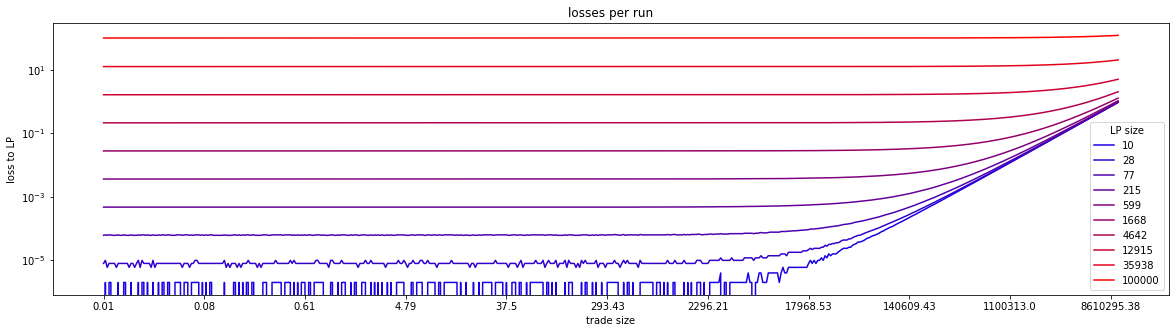

In [3]:
plt.figure(figsize=(20,5))
plt.yscale('log')
# plt.xscale('log')
plt.title('losses per run')
plt.xlabel('trade size')
plt.xticks(
    list(range(len(trade_sizes)))[::55],
    [round(trade_size, 2) for trade_size in trade_sizes[::55]]
)
plt.ylabel('loss to LP')
colors = list(reversed(pu.color_gradient(len(lp_sizes))))
base = sum(events[0][0].agents['LP'].holdings.values())
print ('least loss per run by LP size:')
for i, lp_events in enumerate(events):
    losses = [base - sum(event.agents['LP'].holdings.values())for event in lp_events]
    best = min(losses)
    plt.plot(range(len(lp_events)), losses, color=colors[i])
    print(f'{i}: {best} ({losses.index(best)}) (trade = {trade_sizes[losses.index(best)]}) (LP = {lp_sizes[i]})')
    
plt.legend([str(round(size)) for size in lp_sizes], title='LP size')
